In [1]:
# Import of required libraries and functions from 'make_dataset' script
import os
from make_dataset import Discotope_Dataset
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, roc_auc_score
from tqdm import tqdm
from IPython.display import clear_output
import random

# Importing the style package
from matplotlib import style

C:\Users\minij\anaconda3\envs\special_course\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def data_load(name_set, data_dir, separate=False):
    
    '''
    Function to load training, validation or test data from the folder/directory you have storaged the whole dataset
        - 'name_set': text variable with the type of data set to load ('train', 'test', 'valid')
        - 'data_dir': directory where you have storaged the data set (in my case is '../Data/')
        - 'separate': boolean that returns the PDBs and AF2 sets separately (only when True)
    
    Output:
        - 'X_all': all observations from both solved and predicted structures all together
        - 'y_all': all labels from both solved and predicted structures all together
        - 'N_solved': number of observations from solved structures (in case of wanted to unmerge the 'all' array)
        - 'N_af2': number of observations from predicted structures (in case of wanted to unmerge the 'all' array)
    '''
    
    # 'Pathlib module' load to work with windows path
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    
    # List of all subdirectories inside the data directory
    dirs = [d for d in os.listdir(data_dir)]
    
    # 're' module to use regex for filtering the specific directories according to the type of data set to load
    pattern = '.*' + name_set + '.*'
    R = re.compile(pattern)
    filtered = [folder for folder in dirs if R.match(folder)]
    
    # Loading the data set for solved structures and AlphaFold2 predicted structures
    path_af2 = data_dir + filtered[0] + '/dataset.pt'
    path_solved = data_dir + filtered[1] + '/dataset.pt'
    set_af2 = torch.load(path_af2)
    set_solved = torch.load(path_solved)
    
    # Stack all features and targets to one big array (removing NaN entries)
    X_set_solved = np.concatenate([set_solved[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_solved = np.concatenate([set_solved[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    X_set_af2 = np.concatenate([set_af2[i]["X_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    y_set_af2 = np.concatenate([set_af2[i]["y_arr"] for i in range(0, len(set_solved), 1) if not set_solved[i]['df_stats']['rsa'].isna().any()])
    
    # Nº of observations for each subtype of data set
    N_set_solved = X_set_solved.shape[0]
    N_set_af2 = X_set_af2.shape[0]
    
    # Stack all features and targets from solved and predicted structures into only one big
    X_set_all = np.concatenate((X_set_solved, X_set_af2), axis=0)
    y_set_all = np.concatenate((y_set_solved, y_set_af2), axis=0)
    
    if (separate==True):
        return(X_set_all, y_set_all, X_set_solved, y_set_solved, X_set_af2, y_set_af2)
    else:
        return(X_set_all, y_set_all, N_set_solved, N_set_af2)

In [3]:
def Z_transform_train(X, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
    '''
    
    # Obtain the mean and standard deviation for each feature on the array
    X_mean = np.mean(X[:, cols_to_select], axis=0)
    X_std = np.std(X[:, cols_to_select], axis=0)
    
    # Correcting pLDDT column sd in case of using only PDB set
    X_std[X_std == 0] = 1
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - X_mean)/X_std
    return(X, X_mean, X_std)

In [4]:
def Z_transform_valid(X, mean_train, sd_train, cols_to_select):
    
    '''
    Function to normalize the columns 532 (pLLDT) and 533 (length) because they have high length
        - 'X': data to normalize
        - 'mean_train': mean from standardized training set
        - 'sd_train': standard deviation from standardized training set
    '''
    
    # Z-transform (standardization)
    X[:, cols_to_select] = (X[:, cols_to_select] - mean_train)/sd_train
    return(X)

In [5]:
def ROC_AUC(y_true, y_hat):
    
    '''
    Function to obtain the AUC value based on the ROC curve
        - 'y_true': y original values
        - 'y_hat': y predicted values
        
    Output:
        - 'ROC_auc': AUC value
    '''
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_hat)
    ROC_auc = metrics.auc(fpr, tpr)
    return(ROC_auc)

In [6]:
# Data loading for training, validation, and test data sets (needs a couple of minutes)
X_train, y_train, X_train_PDB, y_train_PDB, X_train_af2, y_train_af2 = data_load(name_set='train', data_dir='../Data/', separate = True)
X_valid, y_valid, X_valid_PDB, y_valid_PDB, X_valid_af2, y_valid_af2 = data_load(name_set='valid', data_dir='../Data/', separate = True)
X_test, y_test, X_test_PDB, y_test_PDB, X_test_af2, y_test_af2 = data_load(name_set='test', data_dir='../Data/', separate = True)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((446835, 536), (446835,), (115978, 536), (115978,), (11882, 536), (11882,))

In [7]:
# Data normalization
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_sc, mean_X_train, sd_X_train = Z_transform_train(X_train, cols_to_select=cols)
X_valid_sc = Z_transform_valid(X_valid, mean_X_train, sd_X_train, cols_to_select=cols)
X_test_sc = Z_transform_valid(X_test, mean_X_train, sd_X_train, cols_to_select=cols)

X_train_sc.shape, X_valid_sc.shape, X_test_sc.shape

((446835, 536), (115978, 536), (11882, 536))

In [8]:
# Data normalization (PDB only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_PDB_sc, mean_X_train_PDB, sd_X_train_PDB = Z_transform_train(X_train_PDB, cols_to_select=cols)
X_valid_PDB_sc = Z_transform_valid(X_valid_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)
X_test_PDB_sc = Z_transform_valid(X_test_PDB, mean_X_train_PDB, sd_X_train_PDB, cols_to_select=cols)

X_train_PDB_sc.shape, X_valid_PDB_sc.shape, X_test_PDB_sc.shape

((223346, 536), (57989, 536), (5941, 536))

In [9]:
# Data normalization (AF2 only)
cols = list(range(0, 512)) + [532] + [533] + [535]
X_train_af2_sc, mean_X_train_af2, sd_X_train_af2 = Z_transform_train(X_train_af2, cols_to_select=cols)
X_valid_af2_sc = Z_transform_valid(X_valid_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)
X_test_af2_sc = Z_transform_valid(X_test_af2, mean_X_train_af2, sd_X_train_af2, cols_to_select=cols)

X_train_af2_sc.shape, X_valid_af2_sc.shape, X_test_af2_sc.shape

((223489, 536), (57989, 536), (5941, 536))

## Reading the ensemble results

In [10]:
# Path to directory containing CSV files
directory_path = '1_Ensemble'

# List to store numpy arrays from CSV files
numpy_arrays = []

# Loop over all CSV files in directory
filenames = []
for filename in os.listdir(directory_path):
    
    # Save the filename in a list
    print(filename)
    filenames.append(filename)
    
    # Load CSV file as numpy array and append to list
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        numpy_array = np.loadtxt(file_path, delimiter=',')
        numpy_arrays.append(numpy_array)

score_af2_af2.csv
score_af2_af2_2.csv
score_af2_solved.csv
score_af2_solved_2.csv
score_both_af2.csv
score_both_af2_2.csv
score_both_solved.csv
score_both_solved_2.csv
score_solved_af2.csv
score_solved_af2_2.csv
score_solved_solved.csv
score_solved_solved_2.csv


In [11]:
# Concatenate the ensemble arrays
score_af2_af2 = np.concatenate((numpy_arrays[0], numpy_arrays[1]), axis=1)
score_af2_af2 = score_af2_af2[:, 0:20]

score_af2_af2.shape

(57989, 20)

In [12]:
# Concatenate the arrays
score_af2_solved = np.concatenate((numpy_arrays[2], numpy_arrays[3]), axis=1)
score_af2_solved = score_af2_solved[:, 0:20]

score_af2_solved.shape

(57989, 20)

In [13]:
# Concatenate the arrays
score_both_af2 = np.concatenate((numpy_arrays[4], numpy_arrays[5]), axis=1)
score_both_af2 = score_both_af2[:, 0:20]

score_both_af2.shape

(57989, 20)

In [14]:
# Concatenate the arrays
score_both_solved = np.concatenate((numpy_arrays[6], numpy_arrays[7]), axis=1)
score_both_solved = score_both_solved[:, 0:20]

score_both_solved.shape

(57989, 20)

In [15]:
# Concatenate the arrays
score_solved_af2 = np.concatenate((numpy_arrays[8], numpy_arrays[9]), axis=1)
score_solved_af2 = score_solved_af2[:, 0:20]

score_solved_af2.shape

(57989, 20)

In [16]:
# Concatenate the arrays
score_solved_solved = np.concatenate((numpy_arrays[10], numpy_arrays[11]), axis=1)
score_solved_solved = score_solved_solved[:, 0:20]

score_solved_solved.shape

(57989, 20)

In [17]:
# Nº of ensembles
K = 20

# Array for storing the mean scores for the ensemble methodology
ensemble_score_both_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_both_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the AUC values from the ensemble scores
ROC_AUC_both_solved = np.empty(K)
ROC_AUC_both_af2 = np.empty(K)
ROC_AUC_solved_solved = np.empty(K)
ROC_AUC_solved_af2 = np.empty(K)
ROC_AUC_af2_solved = np.empty(K)
ROC_AUC_af2_af2 = np.empty(K)

for i in range(0,K,1):

    # Updating the ensemble score arrays
    ensemble_score_both_solved[:, i] = np.mean(score_both_solved[:, :(i+1)], axis=1)
    ensemble_score_both_af2[:, i] = np.mean(score_both_af2[:, :(i+1)], axis=1)
    ensemble_score_solved_solved[:, i] = np.mean(score_solved_solved[:, :(i+1)], axis=1)
    ensemble_score_solved_af2[:, i] = np.mean(score_solved_af2[:, :(i+1)], axis=1)
    ensemble_score_af2_solved[:, i] = np.mean(score_af2_solved[:, :(i+1)], axis=1)
    ensemble_score_af2_af2[:, i] = np.mean(score_af2_af2[:, :(i+1)], axis=1)
    
    # ROC-AUC values update according to the ensemble scores
    ROC_AUC_both_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_both_solved[:, i])
    ROC_AUC_both_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_both_af2[:, i])
    ROC_AUC_solved_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_solved_solved[:, i])
    ROC_AUC_solved_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_solved_af2[:, i])
    ROC_AUC_af2_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_af2_solved[:, i])
    ROC_AUC_af2_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_af2_af2[:, i])

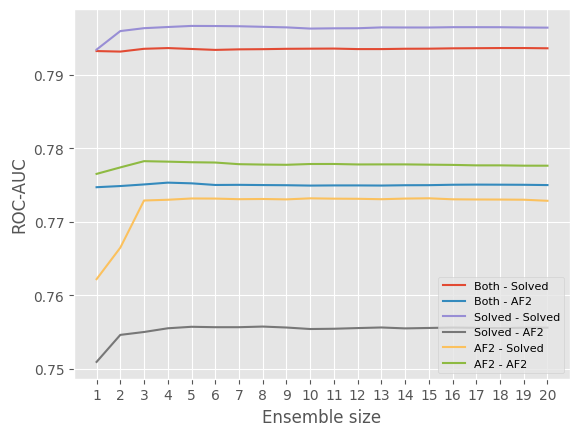

In [18]:
# Using the style for the plot
plt.style.use('ggplot')

# Plot ensemble curve
plt.plot(range(1, len(ROC_AUC_both_solved) + 1), ROC_AUC_both_solved, label = 'Both - Solved')
plt.plot(range(1, len(ROC_AUC_both_af2) + 1), ROC_AUC_both_af2, label = 'Both - AF2')
plt.plot(range(1, len(ROC_AUC_solved_solved) + 1), ROC_AUC_solved_solved, label = 'Solved - Solved')
plt.plot(range(1, len(ROC_AUC_solved_af2) + 1), ROC_AUC_solved_af2, label = 'Solved - AF2')
plt.plot(range(1, len(ROC_AUC_af2_solved) + 1), ROC_AUC_af2_solved, label = 'AF2 - Solved')
plt.plot(range(1, len(ROC_AUC_af2_af2) + 1), ROC_AUC_af2_af2, label = 'AF2 - AF2')

plt.ylabel('ROC-AUC')
plt.xlabel('Ensemble size')
plt.xticks(range(1, len(ROC_AUC_both_solved) + 1))
plt.legend(loc='lower right', fontsize = 8)
plt.savefig('1NN_ensemble.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [19]:
print('Ensemble results for structure of 1 hidden units: \n')
print('Solved - Solved:', str(ROC_AUC_solved_solved[-1]))
print('Both - Solved:\t', str(ROC_AUC_both_solved[-1]))
print('AF2 - AF2:\t', str(ROC_AUC_af2_af2[-1]))
print('Both - AF2:\t', str(ROC_AUC_both_af2[-1]))
print('AF2 - Solved:\t', str(ROC_AUC_af2_solved[-1]))
print('Solved - AF2:\t', str(ROC_AUC_solved_af2[-1]))

Ensemble results for structure of 1 hidden units: 

Solved - Solved: 0.7964398245038363
Both - Solved:	 0.7936288832333496
AF2 - AF2:	 0.7776410363191336
Both - AF2:	 0.7750035600067197
AF2 - Solved:	 0.7728633267497413
Solved - AF2:	 0.7555849224491591


In [20]:
gain_both_solved = ROC_AUC_both_solved[-1] - ROC_AUC_both_solved[0]
gain_both_af2 = ROC_AUC_both_af2[-1] - ROC_AUC_both_af2[0]
gain_solved_solved = ROC_AUC_solved_solved[-1] - ROC_AUC_solved_solved[0]
gain_solved_af2 = ROC_AUC_solved_af2[-1] - ROC_AUC_solved_af2[0]
gain_af2_solved = ROC_AUC_af2_solved[-1] - ROC_AUC_af2_solved[0]
gain_af2_af2 = ROC_AUC_af2_af2[-1] - ROC_AUC_af2_af2[0]

In [21]:
print('Gain from the data-ensemble for structure of 1 hidden units: \n')
print('Both - Solved:', str(gain_both_solved*100), '%')
print('Both - AF2:\t', str(gain_both_af2*100), '%')
print('Solved - Solved:\t', str(gain_solved_solved*100), '%')
print('Solved - AF2:\t', str(gain_solved_af2*100), '%')
print('AF2 - Solved:\t', str(gain_af2_solved*100), '%')
print('AF2 - AF2:\t', str(gain_af2_af2*100), '%')

Gain from the data-ensemble for structure of 1 hidden units: 

Both - Solved: 0.03775608890674853 %
Both - AF2:	 0.029191858849464403 %
Solved - Solved:	 0.29886550789166577 %
Solved - AF2:	 0.46625137179973075 %
AF2 - Solved:	 1.0672837344980701 %
AF2 - AF2:	 0.11153673754232818 %


## Reading the ensemble results (10 hu)

In [22]:
# Path to directory containing CSV files
directory_path = '10_Ensemble'

# List to store numpy arrays from CSV files
numpy_arrays = []

# Loop over all CSV files in directory
filenames = []
for filename in os.listdir(directory_path):
    
    # Save the filename in a list
    print(filename)
    filenames.append(filename)
    
    # Load CSV file as numpy array and append to list
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        numpy_array = np.loadtxt(file_path, delimiter=',')
        numpy_arrays.append(numpy_array)

score_af2_af2_10.csv
score_af2_solved_10.csv
score_both_af2_10.csv
score_both_solved_10.csv
score_solved_af2_10.csv
score_solved_solved_10.csv


In [23]:
# Concatenate the ensemble arrays
score_af2_af2 = numpy_arrays[1]
score_af2_af2 = score_af2_af2[:, 0:20]

score_af2_af2.shape

(57989, 20)

In [24]:
# Concatenate the arrays
score_af2_solved = numpy_arrays[1]
score_af2_solved = score_af2_solved[:, 0:20]

score_af2_solved.shape

(57989, 20)

In [25]:
# Concatenate the arrays
score_both_af2 = numpy_arrays[2]
score_both_af2 = score_both_af2[:, 0:20]

score_both_af2.shape

(57989, 20)

In [26]:
# Concatenate the arrays
score_both_solved = numpy_arrays[3]
score_both_solved = score_both_solved[:, 0:20]

score_both_solved.shape

(57989, 20)

In [27]:
# Concatenate the arrays
score_solved_af2 = numpy_arrays[4]
score_solved_af2 = score_solved_af2[:, 0:20]

score_solved_af2.shape

(57989, 20)

In [28]:
# Concatenate the arrays
score_solved_solved = numpy_arrays[5]
score_solved_solved = score_solved_solved[:, 0:20]

score_solved_solved.shape

(57989, 20)

In [29]:
# Nº of ensembles
K = 20

# Array for storing the mean scores for the ensemble methodology
ensemble_score_both_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_both_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_solved_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_solved_af2 = np.empty((len(X_valid_af2_sc), K))
ensemble_score_af2_solved = np.empty((len(X_valid_PDB_sc), K))
ensemble_score_af2_af2 = np.empty((len(X_valid_af2_sc), K))

# Array for storing the AUC values from the ensemble scores
ROC_AUC_both_solved = np.empty(K)
ROC_AUC_both_af2 = np.empty(K)
ROC_AUC_solved_solved = np.empty(K)
ROC_AUC_solved_af2 = np.empty(K)
ROC_AUC_af2_solved = np.empty(K)
ROC_AUC_af2_af2 = np.empty(K)

for i in range(0,K,1):

    # Updating the ensemble score arrays
    ensemble_score_both_solved[:, i] = np.mean(score_both_solved[:, :(i+1)], axis=1)
    ensemble_score_both_af2[:, i] = np.mean(score_both_af2[:, :(i+1)], axis=1)
    ensemble_score_solved_solved[:, i] = np.mean(score_solved_solved[:, :(i+1)], axis=1)
    ensemble_score_solved_af2[:, i] = np.mean(score_solved_af2[:, :(i+1)], axis=1)
    ensemble_score_af2_solved[:, i] = np.mean(score_af2_solved[:, :(i+1)], axis=1)
    ensemble_score_af2_af2[:, i] = np.mean(score_af2_af2[:, :(i+1)], axis=1)
    
    # ROC-AUC values update according to the ensemble scores
    ROC_AUC_both_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_both_solved[:, i])
    ROC_AUC_both_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_both_af2[:, i])
    ROC_AUC_solved_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_solved_solved[:, i])
    ROC_AUC_solved_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_solved_af2[:, i])
    ROC_AUC_af2_solved[i] = ROC_AUC(y_valid_PDB, ensemble_score_af2_solved[:, i])
    ROC_AUC_af2_af2[i] = ROC_AUC(y_valid_af2, ensemble_score_af2_af2[:, i])

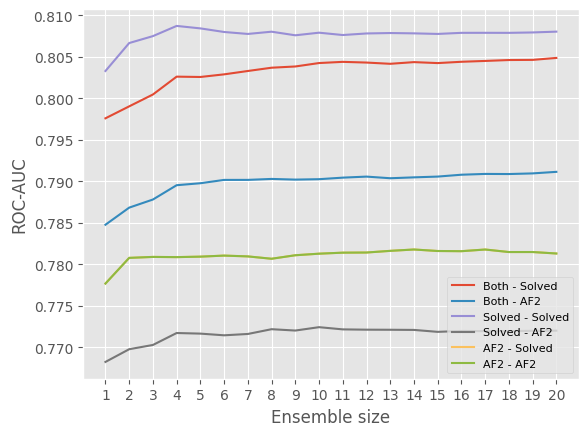

In [30]:
# Using the style for the plot
plt.style.use('ggplot')

# Plot ensemble curve
plt.plot(range(1, len(ROC_AUC_both_solved) + 1), ROC_AUC_both_solved, label = 'Both - Solved')
plt.plot(range(1, len(ROC_AUC_both_af2) + 1), ROC_AUC_both_af2, label = 'Both - AF2')
plt.plot(range(1, len(ROC_AUC_solved_solved) + 1), ROC_AUC_solved_solved, label = 'Solved - Solved')
plt.plot(range(1, len(ROC_AUC_solved_af2) + 1), ROC_AUC_solved_af2, label = 'Solved - AF2')
plt.plot(range(1, len(ROC_AUC_af2_solved) + 1), ROC_AUC_af2_solved, label = 'AF2 - Solved')
plt.plot(range(1, len(ROC_AUC_af2_af2) + 1), ROC_AUC_af2_af2, label = 'AF2 - AF2')

plt.ylabel('ROC-AUC')
plt.xlabel('Ensemble size')
plt.xticks(range(1, len(ROC_AUC_both_solved) + 1))
plt.legend(loc='lower right', fontsize = 8)
plt.savefig('10NN_ensemble.png', format='png', dpi=1200, facecolor='white', bbox_inches='tight')

In [31]:
print('Ensemble results for structure of 10 hidden units: \n')
print('Solved - Solved:', str(ROC_AUC_solved_solved[-1]))
print('Both - Solved:\t', str(ROC_AUC_both_solved[-1]))
print('AF2 - AF2:\t', str(ROC_AUC_af2_af2[-1]))
print('Both - AF2:\t', str(ROC_AUC_both_af2[-1]))
print('AF2 - Solved:\t', str(ROC_AUC_af2_solved[-1]))
print('Solved - AF2:\t', str(ROC_AUC_solved_af2[-1]))

Ensemble results for structure of 10 hidden units: 

Solved - Solved: 0.8080206872893237
Both - Solved:	 0.8048532547174996
AF2 - AF2:	 0.781288408429719
Both - AF2:	 0.7911271601429968
AF2 - Solved:	 0.781288408429719
Solved - AF2:	 0.7719932210720997


In [32]:
gain_both_solved = ROC_AUC_both_solved[-1] - ROC_AUC_both_solved[0]
gain_both_af2 = ROC_AUC_both_af2[-1] - ROC_AUC_both_af2[0]
gain_solved_solved = ROC_AUC_solved_solved[-1] - ROC_AUC_solved_solved[0]
gain_solved_af2 = ROC_AUC_solved_af2[-1] - ROC_AUC_solved_af2[0]
gain_af2_solved = ROC_AUC_af2_solved[-1] - ROC_AUC_af2_solved[0]
gain_af2_af2 = ROC_AUC_af2_af2[-1] - ROC_AUC_af2_af2[0]

In [33]:
print('Gain from the data-ensemble for structure of 10 hidden units: \n')
print('Both - Solved:', str(gain_both_solved*100), '%')
print('Both - AF2:\t', str(gain_both_af2*100), '%')
print('Solved - Solved:\t', str(gain_solved_solved*100), '%')
print('Solved - AF2:\t', str(gain_solved_af2*100), '%')
print('AF2 - Solved:\t', str(gain_af2_solved*100), '%')
print('AF2 - AF2:\t', str(gain_af2_af2*100), '%')

Gain from the data-ensemble for structure of 10 hidden units: 

Both - Solved: 0.7274960082394366 %
Both - AF2:	 0.6373308898682262 %
Solved - Solved:	 0.47420506266711016 %
Solved - AF2:	 0.376817879947311 %
AF2 - Solved:	 0.36213353910982127 %
AF2 - AF2:	 0.36213353910982127 %
